# DiscreteDP Example: Water Management

**Daisuke Oyama**

*Faculty of Economics, University of Tokyo*

From Miranda and Fackler, <i>Applied Computational Economics and Finance</i>, 2002,
Section 7.6.5

In [1]:
%matplotlib inline

In [2]:
import itertools
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from quantecon.markov import DiscreteDP

In [3]:
maxcap = 30
n = maxcap + 1  # Number of states
m = n           # Number of actions

a1, b1 = 14, 0.8
a2, b2 = 10, 0.4
F = lambda x: a1 * x**b1  # Benefit from irrigation
U = lambda c: a2 * c**b2  # Benefit from recreational consumption c = s - x

probs = [0.1, 0.2, 0.4, 0.2, 0.1]
supp_size = len(probs)

beta = 0.9

## Product formulation

In [4]:
# Reward array
R = np.empty((n, m))
for s, x in itertools.product(range(n), range(m)):
    R[s, x] = F(x) + U(s-x) if x <= s else -np.inf

In [5]:
# Transition probability array
Q = np.zeros((n, m, n))
for s, x in itertools.product(range(n), range(m)):
    if x <= s:
        for j in range(supp_size):
            Q[s, x, np.minimum(s-x+j, n-1)] += probs[j]

In [6]:
# Create a DiscreteDP
ddp = DiscreteDP(R, Q, beta)

In [7]:
# Solve the dynamic optimization problem (by policy iteration)
res = ddp.solve()

In [8]:
# Number of iterations
res.num_iter

4

In [9]:
# Optimal policy
res.sigma

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5])

In [10]:
# Optimal value function
res.v

array([ 338.41645251,  361.98791375,  377.4257383 ,  391.4257383 ,
        405.2360958 ,  417.9622843 ,  429.86115765,  441.17106277,
        452.06672421,  462.66012607,  473.03554185,  483.40234488,
        493.51237732,  503.35334776,  512.93797732,  522.31628408,
        531.65601391,  540.88902181,  549.98545145,  558.93954761,
        567.74582688,  576.47074514,  585.14046164,  593.69786291,
        602.15675175,  610.510884  ,  618.80539659,  627.0562497 ,
        635.2098027 ,  643.28164235,  651.27787278])

In [11]:
# Simulate the controlled Markov chain for num_rep times
# and compute the average
init = 0
nyrs = 50
ts_length = nyrs + 1
num_rep = 10**4
ave_path = np.zeros(ts_length)
for i in range(num_rep):
    path = res.mc.simulate(ts_length, init=init)
    ave_path = (i/(i+1)) * ave_path + (1/(i+1)) * path

In [12]:
ave_path

array([  0.    ,   2.0011,   3.69  ,   4.873 ,   5.9352,   6.9338,
         7.815 ,   8.5886,   9.2374,   9.7102,  10.119 ,  10.4787,
        10.7603,  10.9802,  11.1675,  11.3492,  11.5069,  11.6288,
        11.7293,  11.814 ,  11.8893,  11.9602,  12.0263,  12.0765,
        12.1334,  12.1872,  12.2247,  12.2737,  12.3002,  12.3108,
        12.331 ,  12.3481,  12.3692,  12.3836,  12.3946,  12.4119,
        12.4095,  12.4043,  12.4295,  12.4419,  12.4541,  12.4582,
        12.4641,  12.4722,  12.4687,  12.4572,  12.4401,  12.4338,
        12.4385,  12.4362,  12.4379])

In [13]:
# Stationary distribution of the Markov chain
stationary_dist = res.mc.stationary_distributions[0]

In [14]:
stationary_dist

array([  0.00000000e+00,   0.00000000e+00,   1.15115026e-07,
         1.03603524e-06,   8.05805183e-06,   5.98598136e-05,
         4.44344001e-04,   3.29804550e-03,   2.44792103e-02,
         6.08112470e-02,   1.20881706e-01,   1.39769288e-01,
         1.50250205e-01,   1.50250201e-01,   1.39769301e-01,
         1.20881695e-01,   6.08112091e-02,   2.44793930e-02,
         3.29774206e-03,   4.43926815e-04,   5.70763048e-05,
         6.34181165e-06,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

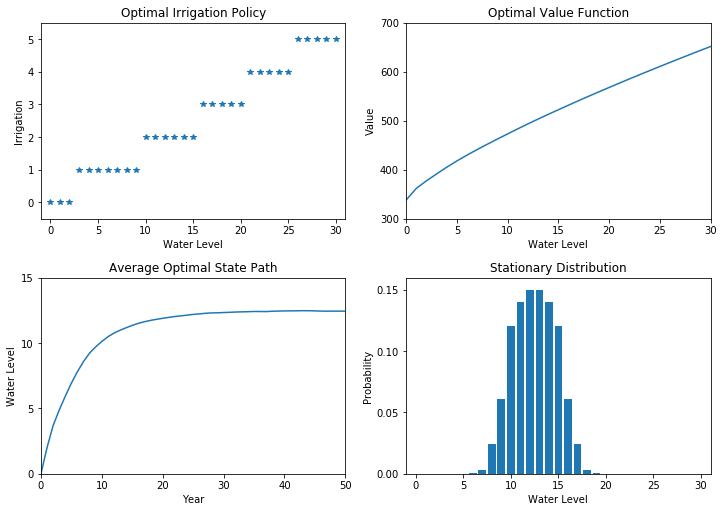

In [15]:
# Plot sigma, v, ave_path, stationary_dist
hspace = 0.3
fig, axes = plt.subplots(2, 2, figsize=(12, 8+hspace))
fig.subplots_adjust(hspace=hspace)

axes[0, 0].plot(res.sigma, '*')
axes[0, 0].set_xlim(-1, 31)
axes[0, 0].set_ylim(-0.5, 5.5)
axes[0, 0].set_xlabel('Water Level')
axes[0, 0].set_ylabel('Irrigation')
axes[0, 0].set_title('Optimal Irrigation Policy')

axes[0, 1].plot(res.v)
axes[0, 1].set_xlim(0, 30)
y_lb, y_ub = 300, 700
axes[0, 1].set_ylim(y_lb, y_ub)
axes[0, 1].set_yticks(np.linspace(y_lb, y_ub, 5, endpoint=True))
axes[0, 1].set_xlabel('Water Level')
axes[0, 1].set_ylabel('Value')
axes[0, 1].set_title('Optimal Value Function')

axes[1, 0].plot(ave_path)
axes[1, 0].set_xlim(0, nyrs)
y_lb, y_ub = 0, 15
axes[1, 0].set_ylim(y_lb, y_ub)
axes[1, 0].set_yticks(np.linspace(y_lb, y_ub, 4, endpoint=True))
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Water Level')
axes[1, 0].set_title('Average Optimal State Path')

axes[1, 1].bar(range(n), stationary_dist, align='center')
axes[1, 1].set_xlim(-1, n)
y_lb, y_ub = 0, 0.15
axes[1, 1].set_ylim(y_lb, y_ub+0.01)
axes[1, 1].set_yticks(np.linspace(y_lb, y_ub, 4, endpoint=True))
axes[1, 1].set_xlabel('Water Level')
axes[1, 1].set_ylabel('Probability')
axes[1, 1].set_title('Stationary Distribution')

plt.show()

## State-action pairs formulation

In [16]:
# Arrays of state and action indices
S = np.arange(n)
X = np.arange(m)
S_left = S.reshape(n, 1) - X.reshape(1, n)
s_indices, a_indices = np.where(S_left >= 0)

In [17]:
# Reward vector
S_left = S_left[s_indices, a_indices]
R = F(X[a_indices]) + U(S_left)

In [18]:
# Transition probability array
L = len(S_left)
Q = sparse.lil_matrix((L, n))
for i, s_left in enumerate(S_left):
    for j in range(supp_size):
        Q[i, np.minimum(s_left+j, n-1)] += probs[j]

In [19]:
# Create a DiscreteDP
ddp = DiscreteDP(R, Q, beta, s_indices, a_indices)

In [20]:
# Solve the dynamic optimization problem (by policy iteration)
res = ddp.solve()

In [21]:
# Number of iterations
res.num_iter

4

In [22]:
# Simulate the controlled Markov chain for num_rep times
# and compute the average
init = 0
nyrs = 50
ts_length = nyrs + 1
num_rep = 10**4
ave_path = np.zeros(ts_length)
for i in range(num_rep):
    path = res.mc.simulate(ts_length, init=init)
    ave_path = (i/(i+1)) * ave_path + (1/(i+1)) * path

In [23]:
# Stationary distribution of the Markov chain
stationary_dist = res.mc.stationary_distributions[0]

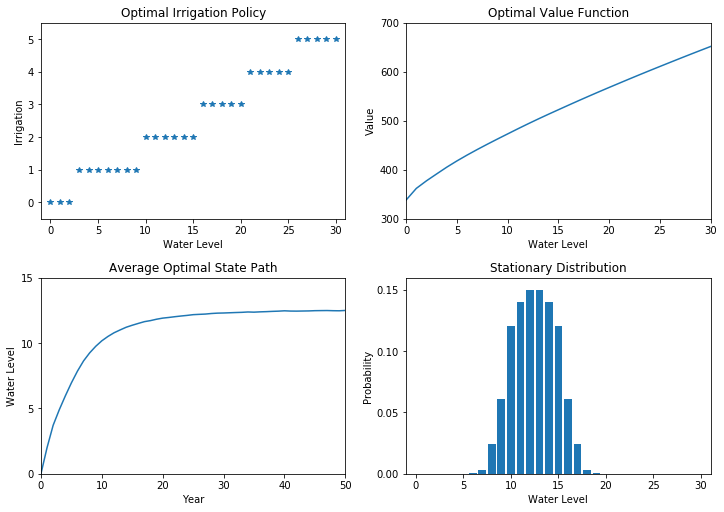

In [24]:
# Plot sigma, v, ave_path, stationary_dist
hspace = 0.3
fig, axes = plt.subplots(2, 2, figsize=(12, 8+hspace))
fig.subplots_adjust(hspace=hspace)

axes[0, 0].plot(res.sigma, '*')
axes[0, 0].set_xlim(-1, 31)
axes[0, 0].set_ylim(-0.5, 5.5)
axes[0, 0].set_xlabel('Water Level')
axes[0, 0].set_ylabel('Irrigation')
axes[0, 0].set_title('Optimal Irrigation Policy')

axes[0, 1].plot(res.v)
axes[0, 1].set_xlim(0, 30)
y_lb, y_ub = 300, 700
axes[0, 1].set_ylim(y_lb, y_ub)
axes[0, 1].set_yticks(np.linspace(y_lb, y_ub, 5, endpoint=True))
axes[0, 1].set_xlabel('Water Level')
axes[0, 1].set_ylabel('Value')
axes[0, 1].set_title('Optimal Value Function')

axes[1, 0].plot(ave_path)
axes[1, 0].set_xlim(0, nyrs)
y_lb, y_ub = 0, 15
axes[1, 0].set_ylim(y_lb, y_ub)
axes[1, 0].set_yticks(np.linspace(y_lb, y_ub, 4, endpoint=True))
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Water Level')
axes[1, 0].set_title('Average Optimal State Path')

axes[1, 1].bar(range(n), stationary_dist, align='center')
axes[1, 1].set_xlim(-1, n)
y_lb, y_ub = 0, 0.15
axes[1, 1].set_ylim(y_lb, y_ub+0.01)
axes[1, 1].set_yticks(np.linspace(y_lb, y_ub, 4, endpoint=True))
axes[1, 1].set_xlabel('Water Level')
axes[1, 1].set_ylabel('Probability')
axes[1, 1].set_title('Stationary Distribution')

plt.show()